# Logistic model

## Imports

In [1]:
# IMPORT THE NECESSARY LIBRARIES
import pandas as pd
import re # This module provides functions for working with regular expressions allowing search, match and manipulate strings based on patterns
import os # This module allows interaction with the operating system, such as working with files, directories, environment variables, and system commands.
import sys # This module provides access to system-specific parameters, including command-line arguments (sys.argv), standard input/output, and exiting the program (sys.exit()).
import matplotlib.pyplot as plt
import scipy.optimize as opt
from matplotlib.ticker import MaxNLocator
from statsmodels.graphics.tsaplots import plot_acf # This function is used for plotting the Autocorrelation Function (ACF), which is helpful in time series analysis to measure how observations are correlated with their past values.
from mice_inspection_utils import * # Import all functions 
                                    # NOTICE: this is different from import mice_inspection_utils! In that case you'd have to use the module name as a prefic to access functions, classes or variables. E.g. mice_inspection_utils.some_function()
from scipy.stats import linregress
from glob import glob

# This part avoids possible conflict due to the structure of mice_inspection_utils
if not os.path.exists('Data/by_mouse'): 
    os.makedirs('Data/by_mouse')

# GET THE NECESSARY DATA
imput_subj_paths = [f"Data/raw/total.full.rn.RA.total_OTU_table.mouse{i+1}.ovr0.0p.csv" for i in range(0, 8)]
output_subj_paths = [f"Data/by_mouse/mouse_{i+1}.csv" for i in range(0, 8)]
metadata_path = "Data/raw/OTU_table.csv"
mi = Mice_Inspection(ip = imput_subj_paths, op = output_subj_paths, mdp = metadata_path)

## Data structure

In [2]:
# By calling mice_df we have the dataframes for each mouse
df = mi.mice_df[0]
df.head() # -> As we can see we have the bacterial species, the median, the mean counts, and the counts per day (at day 1, 8, 9 ...)

,Unnamed: 0,species,median_counts,mean_counts,1,8,9,10,15,17,...,1001,1004,1010,1016,1022,1028,1029,1035,1039,1044
0,0,Prevotella sp. Smarlab 121567,412.0,415.156682,0,0,0,2,10,18,...,220,248,252,286,346,293,277,190,222,364
1,1,Parabacteroides distasonis,205.5,206.709677,0,0,0,2,41,145,...,136,157,206,133,177,105,163,147,208,222
2,3,Barnesiella intestinihominis,142.0,145.419355,0,0,0,1,19,58,...,158,145,184,131,145,154,119,130,71,161
3,4,Barnesiella viscericola,125.5,137.092166,0,1,0,1,112,195,...,66,85,134,96,126,121,92,71,72,147
4,2,Lactobacillus taiwanensis,123.5,174.769585,0,422,309,0,48,15,...,36,162,282,174,100,306,517,193,513,175


In [3]:

# By calling get_species_df
df = mi.get_species_df(species = 'Prevotella sp. Smarlab 121567')
df.head(10) # -> As we can see we have the count per day of the selected species in each mouse

,day,mouse_1,mouse_2,mouse_3,mouse_4,mouse_5,mouse_6,mouse_7,mouse_8,mean,std
0,0,0,1,0,0,0,0,0,2,0.375,0.744024
1,1,0,0,0,0,0,0,0,1,0.125,0.353553
2,2,0,1,1,0,0,0,0,2,0.500,0.755929
3,3,0,0,0,0,2,0,0,0,0.250,0.707107
4,4,0,0,0,0,0,0,0,0,0.000,0.000000
5,5,0,0,0,0,0,0,0,0,0.000,0.000000
6,6,0,0,0,0,0,0,0,0,0.000,0.000000
7,7,0,0,0,0,0,0,0,0,0.000,0.000000
8,8,0,0,0,0,0,0,0,7,0.875,2.474874
9,9,0,0,9,0,1,60,0,0,8.750,20.940392


## Dissimilarity computation

First of all we create the dataframes with the dissimilarity values for each mouse. 

In [4]:
mice_diss = []
oracle_file = os.path.join(os.getcwd(), "Data" ,"dissimilarities")  # Construct the path Data/dissimilarities in the current working directory (cwd)
                                                                    # "oracle" because is a source of truth or knowledge (folder that if exists, that's what we get data from)

if not os.path.exists(oracle_file): # If the folder does not exist, compute and store dissimilarities
    for mouse in range(1,2): 
        df = mi.get_dissimilarities(mouse, write = True)
        mice_diss.append(df)
    print("Database created")
else: # If the file exists, load precomputed dissimilarities
    for mouse in range(1,9): 
        folder_path = os.path.join(oracle_file, f"dissimilarity_{mouse}.csv")
        csv_files = glob(folder_path)  # Get all CSV file in folder (in general glob finds all files that match a pattern)
        df_list = [pd.read_csv(file,index_col=0)  for file in csv_files]   # Read and merge all files
        mice_diss.append(pd.concat(df_list,ignore_index=False))
        
    print("Data take from files; if you want to compute again delete folder")

Data take from files; if you want to compute again delete folder


In [5]:
# Check that it was built correctly considering for example the first mouse
mice_diss[0].head()

,1,2,3,4,5,6,7,8,9,10,...,1027,1028,1029,1030,1031,1034,1035,1036,1038,1043
Prevotella sp. Smarlab 121567,0.152198,0.171746,0.062899,0.094635,0.111559,0.100248,0.159679,0.158560,0.198151,0.141593,...,0.940133,1.0,0.930256,1.000000,1.000000,0.989131,1.000000,1.000000,1.0,1.0
Parabacteroides distasonis,0.063016,0.084766,0.051827,0.052748,0.085593,0.070336,0.085282,0.074986,0.091216,0.080886,...,0.681340,1.0,0.717952,1.000000,1.000000,0.982302,1.000000,1.000000,1.0,1.0
Barnesiella intestinihominis,0.137988,0.090815,0.087523,0.109374,0.123000,0.083900,0.144142,0.103052,0.126055,0.137472,...,0.740400,1.0,0.783781,1.000000,1.000000,0.987731,1.000000,1.000000,1.0,1.0
Barnesiella viscericola,0.160086,0.079281,0.060972,0.120502,0.157528,0.097143,0.143658,0.096437,0.122690,0.106828,...,0.654971,1.0,0.482109,1.000000,0.945956,0.986578,1.000000,0.973156,1.0,1.0
Lactobacillus taiwanensis,0.378027,0.294579,0.240163,0.315811,0.377685,0.302834,0.428027,0.476685,0.378278,0.271188,...,0.615931,1.0,0.662169,0.061591,0.009472,1.000000,0.076651,0.171177,1.0,1.0


Let's now have a graphical visualization of these dissimilarities

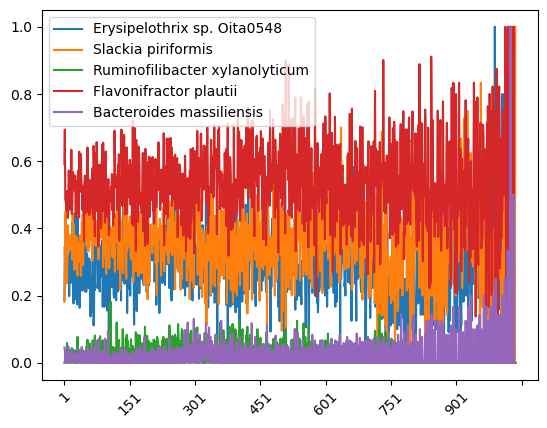

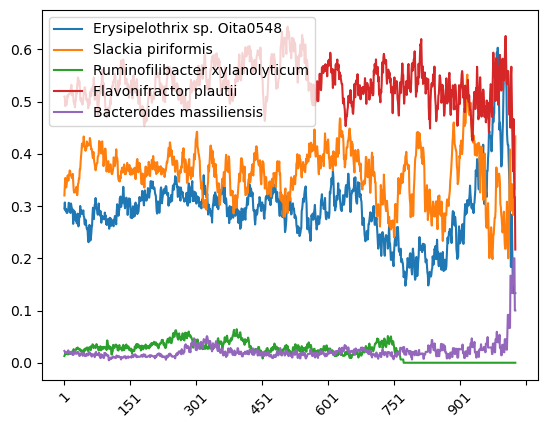

In [6]:
# For the first mice (mice_diss[0])
species = np.asarray(mice_diss[0].index)
n_species = 5
rnd_idx = np.random.choice(np.arange(len(species)), n_species)
species = species[rnd_idx]
lags = np.asarray(mice_diss[0].columns)

for sp in species: 
    data = mice_diss[0].loc[sp].values
    plt.plot(lags, data, label = sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()

# Let's smooth the data a bit for better visualization
def moving_average(data, window_size=5): #This means that for each point t, we take the average of the previous W points.
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

for sp in species: 
    data = mice_diss[0].loc[sp].values
    smoothed_data = moving_average(data, window_size=10)
    plt.plot(lags[:len(smoothed_data)], smoothed_data, label=sp)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xticks(rotation=45)
plt.legend()
plt.show()   


In [7]:
# Let's make one file per mouse where I get one or more pages of graphs in which I can see 
plot_dissimilarities_in_pdf(mice_diss, n_species_per_plot=5, window_size=10, ma = True)

Plots saved in Inspection_Outputs/dissimilarity_1_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_2_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_3_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_4_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_5_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_6_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_7_plot.pdf
Plots saved in Inspection_Outputs/dissimilarity_8_plot.pdf


## Linear fit of dissimilarities


NOTICE: To discriminate between stationary and non-stationary abundancies perform a linear fit, set a threshold and discriminate slopes above/below that threshold.

In [ ]:
# Discard the initial transient (T > 10) 
for idx, mouse_df in enumerate(mice_diss): 
    #ARE WE SURE WE WANT LOSE THE INITIAL DATA??   MAYBE WE CAN SAVE IN ANOTHER DF CALLED mice_diss_cut
    mice_diss[idx] = mouse_df.drop(mouse_df.columns[:10], axis=1)

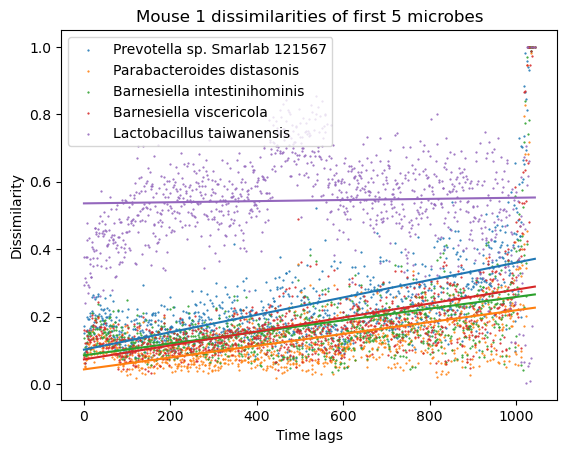

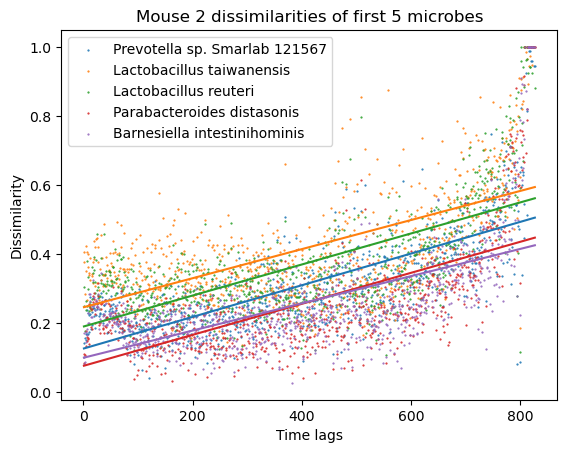

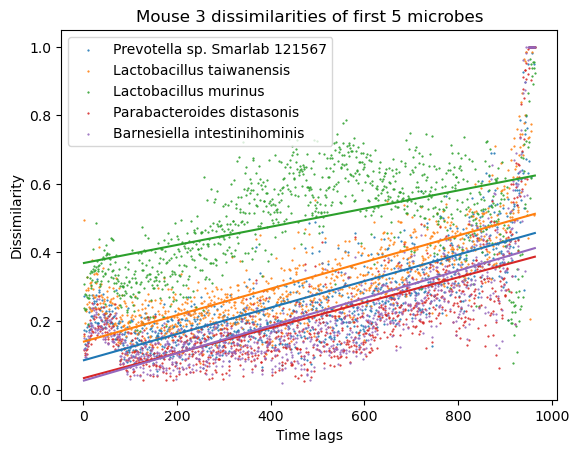

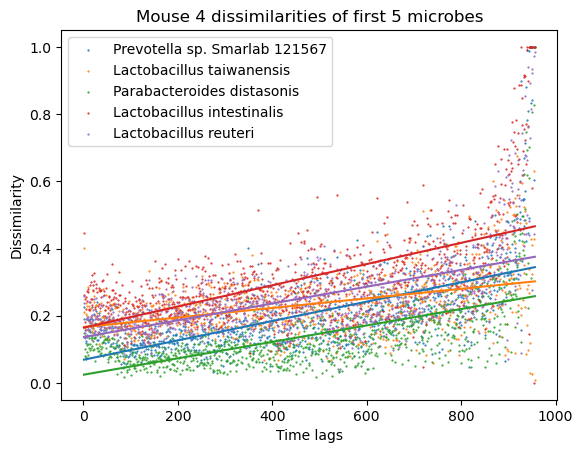

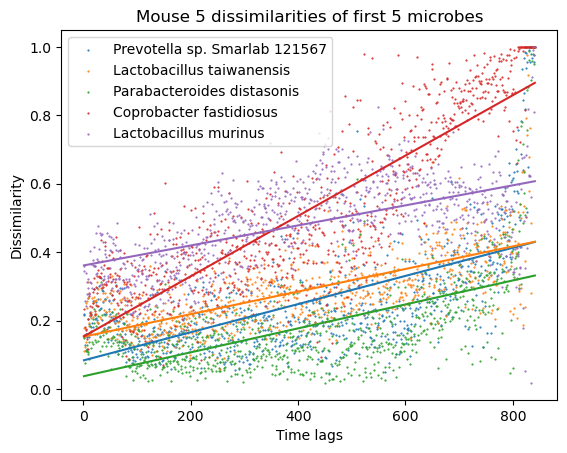

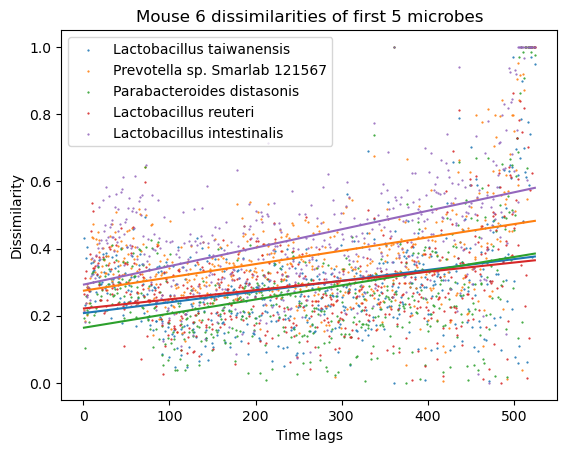

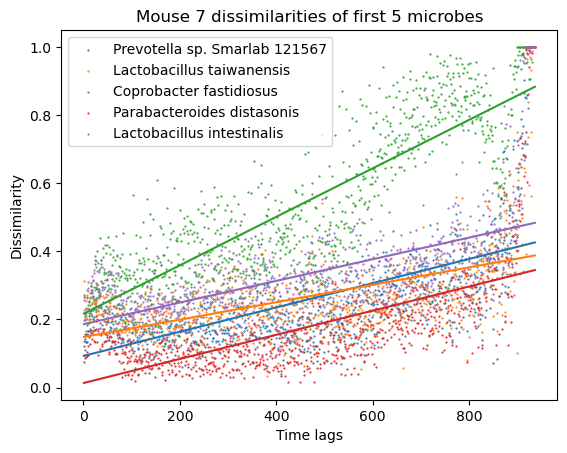

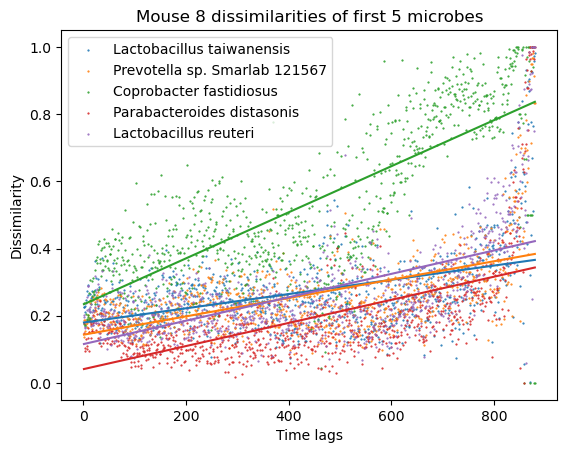

In [ ]:
# Perform a linear fit
for idx, mouse_df in enumerate(mice_diss): 
    data = mouse_df.head(5)
    sp_m = []
    sp_q = []
    sp_pred = []
    for sp_idx in range(len(data)): 
        sp_data = np.asarray(data.iloc[sp_idx, :])
        lags = np.asarray(data.columns, dtype = int)
        m, q, *_ = linregress(lags, sp_data)
        pred_data = m*lags + q
        sp_m.append(m)
        sp_q.append(q)
        sp_pred.append(pred_data)
        plt.scatter(lags, sp_data, s = 0.3, label = f'{mouse_df.index[sp_idx]}')
        plt.plot(lags, pred_data)
        plt.xlabel("Time lags")
        plt.ylabel("Dissimilarity")
    plt.title(f"Mouse {idx + 1} dissimilarities of first 5 microbes")
    plt.legend()
    plt.show()


## Identify the threshold for increasing curves

"To establish the threshold, we accounted for the fact that, although we
expect a flat dissimilarity if the abundance is stationary, a slope different from zero can be found because of the noise in the estimation of $\Phi$, which depends on the length and density of the time series, on the
sequencing depth, and from the OTU parameters. Therefore, for each individual, we computed the threshold as follows:

1.  We simulated the dynamics of each OTU according to the SLM with parameters equal to the parameters estimated for that OTU and $\tau$ = 1. 

2. From these time series of $\vec{\lambda}$, we sampled the time series of $\vec{x}$ according to the sampling depth of the corresponding samples in the data, obtaining therefore values of $\vec{x}$ only for days for which the individual was sampled. 

3. We then computed $\tilde{\Phi}_i(T)$ and its slope for each
OTU. We defined as threshold for an individual the 95% quantile of
the slopes obtained for that individual, i.e., the value such that only
5% of slopes obtained from the simulation are larger." 

(from the article)

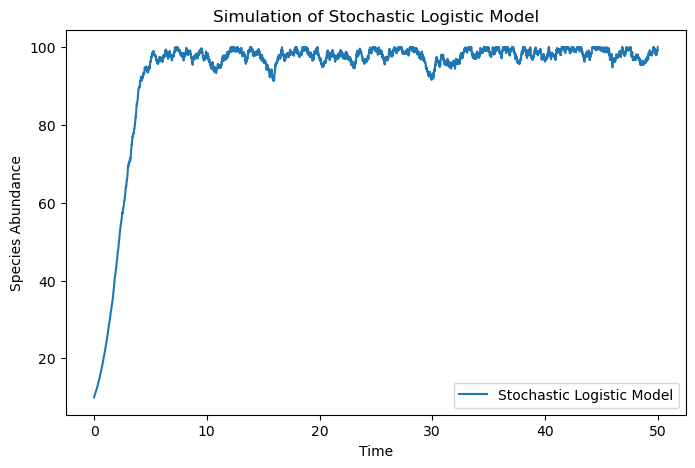

In [8]:
# Fit data of each OTU with SLM to get the parameters estimated for each OTU

def simulate_SLM(ab0, K, sigma, tau, steps, dt): 
    ab_vals = np.zeros(int(steps) + 1) # This is gonna be a vector of abundances at each time t for that species of that mouse
    ab_vals[0] = ab0
    for t in range(1, steps + 1): 
        ab = ab_vals[t-1]
        ab_vals[t] = ab + ( (ab/tau)*(1 - (ab / K)) +  ab * np.sqrt(sigma/tau) * np.random.normal() ) * dt[t-1]
        # Prevent numerical issues
        ab_vals[t] = max(0, min(ab_vals[t], 1*K))  # Ensuring non-negative & not exploding (K is the maximum sustainable population size given the environmental constraints)
    return ab_vals

# Random trial just to see if the function defined above works

# Parameters
ab0 = 10   # Initial population size
K = 100    # Carrying capacity
sigma = 0.1  # Noise intensity
tau = 1.0  # Characteristic time scale
steps = 5000  # Number of steps
dt = np.asarray([0.01]*steps)  # Time step

# Run simulation
ab_vals = simulate_SLM(ab0, K, sigma, tau, steps, dt)

# Plot results
time_vals = np.linspace(0, steps * dt[0], steps + 1)
plt.figure(figsize=(8, 5))
plt.plot(time_vals, ab_vals, label="Stochastic Logistic Model")
plt.xlabel("Time")
plt.ylabel("Species Abundance")
plt.title("Simulation of Stochastic Logistic Model")
plt.legend()
plt.show()

In [9]:
print(mi.mice_df[0].columns)

Index([   'Unnamed: 0',       'species', 'median_counts',   'mean_counts',
                     1,               8,               9,              10,
                    15,              17,
       ...
                  1001,            1004,            1010,            1016,
                  1022,            1028,            1029,            1035,
                  1039,            1044],
      dtype='object', length=221)


In [10]:
# Let's now fit this SLM simulation to our empirical time series 
# NOTICE: we have to fit ABUNDANCIES not dissimilarity!! 
# Let's get the data cleaning it from the columns that do not correspond to species names or abundancies
mice_ab = []
for mouse_num in range(len(mi.mice_df)): 
    columns = mi.mice_df[mouse_num].columns
    mice_ab.append(mi.mice_df[mouse_num].drop(columns = ['Unnamed: 0', 'median_counts', 'mean_counts']))
print(mice_ab[0])

                           species  1    8    9  10   15   17   20   21    22  \
0    Prevotella sp. Smarlab 121567  0    0    0   2   10   18   21   33     3   
1       Parabacteroides distasonis  0    0    0   2   41  145   43   58    54   
2     Barnesiella intestinihominis  0    0    0   1   19   58   28   52    14   
3          Barnesiella viscericola  0    1    0   1  112  195    8   15     5   
4        Lactobacillus taiwanensis  0  422  309   0   48   15  999  156  1096   
..                             ... ..  ...  ...  ..  ...  ...  ...  ...   ...   
621          Mahella australiensis  0    0    0   0    0    0    0    0     0   
622       Prevotella sp. P2A_FAAD4  0    0    0   0    0    0    0    0     0   
623            Xylanibacter oryzae  0    0    0   0    0    0    0    0     0   
624        Thioflavicoccus mobilis  0    0    0   0    0    0    0    0     0   
625        Prevotella paludivivens  0    0    0   0    0    0    0    0     0   

     ...  1001  1004  1010 

In [11]:
df = mice_ab[0] # Get the DataFrame of the first mice
df.iloc[0][1:]

1         0
8         0
9         0
10        2
15       10
       ... 
1028    293
1029    277
1035    190
1039    222
1044    364
Name: 0, Length: 217, dtype: object

Theoretical K: 522.4765794073937
Theoretical sigma: 0.3463373593128886

After Differential Evolution:
Estimated K: 197.90045551158062
Estimated sigma: 23.691116828108946
Estimated tau: 1.3249981631685868

After L-BFGS-B Refinement:
Refined K: 197.90045697724307
Refined sigma: 23.691117143970594
Refined tau: 1.3249981624755927


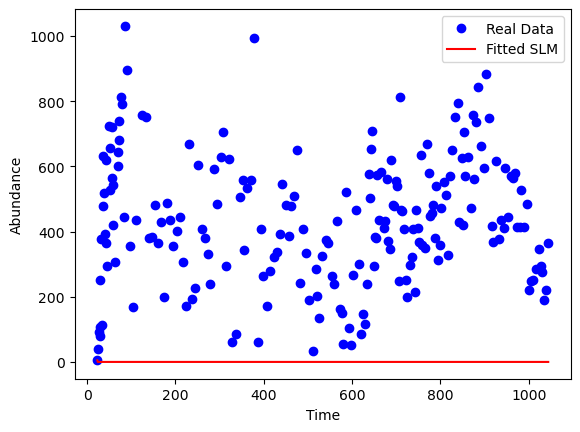

In [ ]:
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt

# Load the first mouse's data
df = mice_ab[0]
species = df['species']
time_series = np.asarray(df.iloc[0][10:])  # Extract the first species' time series
days = np.asarray(df.columns[10:], dtype=int)  # Get measurement days
dt = np.diff(days)  # Compute time intervals

# Objective function for optimization
def objective(params, time_series, dt):
    K, sigma, tau = params
    simulated_data = simulate_SLM(
        ab0=time_series[0], K=K, sigma=sigma, tau=tau, steps=len(time_series)-1, dt=dt
    )
    
    if np.isnan(simulated_data).any():  # Check for NaN values
        return np.inf  # Return a large penalty value
    
    return np.sum((simulated_data - time_series)**2)  # Minimize MSE

# Define parameter bounds
bounds_K = (1, 1e3)  # Carrying capacity
bounds_sigma = (1e-4, time_series.std())  # Stochasticity bounds
bounds_tau = (0.5, 1.5)  # Timescale parameter
bounds = [bounds_K, bounds_sigma, bounds_tau]

# Step 1: Use Differential Evolution for Global Search
result = opt.differential_evolution(objective, bounds, args=(time_series, dt), strategy='best1bin')

K_opt, sigma_opt, tau_opt = result.x
print("\nAfter Differential Evolution:")
print(f"Estimated K: {K_opt}")
print(f"Estimated sigma: {sigma_opt}")
print(f"Estimated tau: {tau_opt}")

# Step 2: Use L-BFGS-B for Local Refinement
result_refined = opt.minimize(objective, [K_opt, sigma_opt, tau_opt], args=(time_series, dt),
                              method='L-BFGS-B', bounds=bounds)

K_opt, sigma_opt, tau_opt = result_refined.x
print("\nAfter L-BFGS-B Refinement:")
print(f"Refined K: {K_opt}")
print(f"Refined sigma: {sigma_opt}")
print(f"Refined tau: {tau_opt}")

# Simulate data using refined parameters
fitted_data = simulate_SLM(
    ab0=time_series[0], K=K_opt, sigma=sigma_opt, tau=tau_opt, steps=len(time_series)-1, dt=dt
)

# Plot real vs fitted data
plt.plot(days, time_series, 'bo', label="Real Data")
plt.plot(days, fitted_data, 'r-', label="Fitted SLM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.legend()
plt.show()


NOTICE: I think it makes more sense not to use curve_fit for fitting a stochastic process BUT I tried anyways because at least in that case we have a reasonable guess for the parameters coming from the theory. In the previous case instead we have to guess the bounds but really I have no clue of how to make them better

In [1]:
df = mice_ab[0] # Get the DataFrame of the first mice
species = df['species'] # Get the species names 
time_series = np.asarray(df.iloc[0][1:]) # Access the data of the first specie. WE ARE DEALING WITH RELATIVE ABUNDANCE (or relative counts) --> the absolute abundance cannot be known (this is the reason why there are statistical artifacts) 
days = np.asarray(df.columns[1:], dtype = int) # Access the days of the measurements
dt = np.asarray([days[i+1] - days[i] for i in range(0, len(days) - 1)]) # Compute the dt

# Estimate K, sigma using theory
var=np.var(time_series)
mean=np.mean(time_series)

sigma_th=2*var/(mean**2+var)
K_th=mean*2/(2-sigma_th)

print("Theoretical K:", K_th)
print("Theoretical sigma:", sigma_th)

# Wrapper function for curve fitting
def SLM_curve_fit(t, K, sigma, tau):
    # Simulate data using SLM
    simulated_abundance = simulate_SLM(
        ab0=time_series[0], K=K, sigma=sigma, tau=tau, steps=len(t)-1, dt=[0.01]*(len(t)-1)
    )
    return simulated_abundance

# Initial guesses for K and sigma
K_guess =K_th
sigma_guess = sigma_th
tau_guess = 1

popt, pcov = opt.curve_fit(SLM_curve_fit, days, time_series, p0=[K_guess, sigma_guess, tau_guess])
K_opt, sigma_opt, tau_opt = popt

print(f"Estimated K: {K_opt}")
print(f"Estimated sigma: {sigma_opt}")

# Simulate data with optimal parameters
fitted_data = SLM_curve_fit(days, K_opt, sigma_opt, tau_opt)

# Plot real vs fitted data
plt.plot(days, time_series, 'bo', label="Real Data")
plt.plot(days, fitted_data, 'r-', label="Fitted SLM")
plt.xlabel("Time")
plt.ylabel("Abundance")
plt.legend()
plt.show()

NameError: name 'mice_ab' is not defined

## WHAT DO YOU THINK OF THESE RESULTS? WHAT DO YOU THINK ABOUT THE IMPOSED BOUNDS? I'M NOT SO SURE AND IDK IF MAYBE WE SHOULD USE CURVE_FIT INSTEAD OF THIS

In [ ]:
# Sample counts for days for which the individual was sampled

In [ ]:
# Compute the dissimilarity for the simulated data 

In [ ]:
# Compute the slope obtained for the dissimilarity of simulated data

In [ ]:
# Compute the treshold for each individual as the 95% quantile of the slopes obtained for that individual

## Stationarity: 

Distinguish OTUs that have stationary dynamics from the others, visualize in a plot $\Phi_i(T)/\Phi_i^\infty$ vs T.  

Perform a taxonomic analysis on species with nonstationary behaviour (common classifications or something else)

## Estimate the parameters of SLM for stationary species

estimate the model parameters $K$ and $\sigma$, from the relations $\left<\lambda\right>=K\left(\frac{2-\sigma}{2}\right)$ and $Var(\lambda)= \left( \frac{\sigma}{2-\sigma} \right) \left<\lambda\right>^2$

        - if $\sigma<2$, the stationary distribution is gamma $$P(\lambda; K, \sigma) = \frac{1}{\Gamma (2/\sigma -1)} \left(\frac{2}{\sigma K}\right)^{2/\sigma -1} \lambda^{2/\sigma-2} e^{-\frac{2}{\sigma K}\lambda} $$
        so we can produce a histogram out of our data and superimpose the theoretical pdf; perform test on distribution

        calculate theoretical expectation value for the dissimilarity at stationarity $\mathbb{E}[\Phi_i^\infty]=\frac{\sigma}{4-\sigma}$, compare with the data.
